In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

# Pytorch basics

## Define tensors

In [2]:
# random Tensor
X = torch.rand(3, 5)

In [3]:
X

tensor([[0.0924, 0.2911, 0.1212, 0.1868, 0.5374],
        [0.3645, 0.5727, 0.5804, 0.6288, 0.0055],
        [0.4104, 0.7801, 0.1654, 0.3685, 0.6012]])

In [4]:
# shape of tensor
X.shape

torch.Size([3, 5])

In [5]:
# type of tensor
X.dtype

torch.float32

In [6]:
# create a tensor from Python
vector = torch.FloatTensor([1, 2, 3, 4, 5])

In [7]:
# you can apply operations similar to how Numpy works
print(vector)
print(vector*2)

tensor([1., 2., 3., 4., 5.])
tensor([ 2.,  4.,  6.,  8., 10.])


In [8]:
integer_vector = torch.LongTensor([1,2, 3, 4, 5])

In [9]:
print(integer_vector)
print(integer_vector/2)

tensor([1, 2, 3, 4, 5])
tensor([0, 1, 1, 2, 2])


# Autograd

Pytorch keep tracks of the gradients automatically

If I wrap a tensor in a Variable object, then Pytorch automatically tracks its gradients:

\begin{align}
b &= w_1 a \\
c &= w_2 a \\
d &= w_3 b + w_4 c \\
L &= 10 - d
\end{align}

In [10]:
a = Variable(torch.FloatTensor([1]), requires_grad=True)
w1, w2, w3, w4 = [Variable(torch.FloatTensor([1]), requires_grad=True),
                  Variable(torch.FloatTensor([2]), requires_grad=True),
                  Variable(torch.FloatTensor([-1]), requires_grad=True),
                  Variable(torch.FloatTensor([4]), requires_grad=True)
                 ]
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d

Let's compute 
$$\frac{dd}{dw_4} = c = 2$$

In [11]:
d.backward()

In [12]:
w4.grad

tensor([2.])

In [13]:
a = Variable(torch.FloatTensor([1]), requires_grad=True)
w1, w2, w3, w4 = [Variable(torch.FloatTensor([1]), requires_grad=True),
                  Variable(torch.FloatTensor([2]), requires_grad=True),
                  Variable(torch.FloatTensor([-1]), requires_grad=True),
                  Variable(torch.FloatTensor([4]), requires_grad=True)
                 ]
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d

In [14]:
L.backward()

Now 

\begin{align}
\frac{dL}{da} &= \frac{dL}{dd} \frac{dd}{db} \frac{db}{da} + \frac{dL}{dd} \frac{dd}{dc} \frac{dc}{da}\\
&= -w_3 w_1 -w_4 w_2\\
&= -7
\end{align}

In [15]:
-w3*w1-w4*w2

tensor([-7.], grad_fn=<ThSubBackward>)

In [16]:
a.grad

tensor([-7.])

# Regression

In [17]:
# generate fake data
from sklearn.datasets import make_regression

In [18]:
X, y = make_regression(n_features=1, n_informative=1, bias=2, noise=20, random_state=0)

In [19]:
X.shape

(100, 1)

In [20]:
y.shape

(100,)

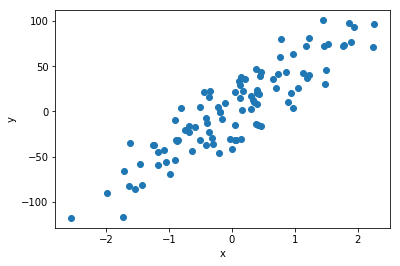

In [21]:
plt.scatter(X, y);
plt.xlabel('x')
plt.ylabel('y');

A simple regression model
$$y = w_1b+w_0$$

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
w0_best, w1_best = [LinearRegression().fit(X, y).intercept_, LinearRegression().fit(X, y).coef_[0]]

Let's find it through autograd

In [24]:
Xt = torch.from_numpy(X).type(torch.float32)
yt = torch.from_numpy(y.reshape(-1, 1)).type(torch.float32)
w = torch.randn(2, 1, requires_grad=True)

In [25]:
learning_rate = 0.001
for i in range(5000): # 10 iterations of gradient descent
    # forward pass
    yp = Xt*w[1] + w[0]
    MSE = ((yp-yt)**2).mean()
    MSE.backward()
    # don't update the gradient
    with torch.no_grad():        
        w -= learning_rate * w.grad
        if i % 500 == 0:
            print("MSE = ", MSE)           

        # Manually zero the gradients after running the backward pass
        w.grad.zero_()
        w.grad.zero_()
print("Final solution")
print(w[0])
print(w[1])
print("Solution found by scikit-learn")
print(w0_best)
print(w1_best)

MSE =  tensor(2230.8096, grad_fn=<MeanBackward1>)
MSE =  tensor(686.4489, grad_fn=<MeanBackward1>)
MSE =  tensor(486.8759, grad_fn=<MeanBackward1>)
MSE =  tensor(460.7115, grad_fn=<MeanBackward1>)
MSE =  tensor(457.2306, grad_fn=<MeanBackward1>)
MSE =  tensor(456.7607, grad_fn=<MeanBackward1>)
MSE =  tensor(456.6963, grad_fn=<MeanBackward1>)
MSE =  tensor(456.6875, grad_fn=<MeanBackward1>)
MSE =  tensor(456.6862, grad_fn=<MeanBackward1>)
MSE =  tensor(456.6860, grad_fn=<MeanBackward1>)
Final solution
tensor([0.3727], grad_fn=<SelectBackward>)
tensor([42.8514], grad_fn=<SelectBackward>)
Solution found by scikit-learn
0.3716363459385481
42.85335572691592


# Higher level API: nn

The subpackage `nn` allows you to define *layers* that are connected sequentially or in any other fashion

In [26]:
# let's define a complex regression
X = np.linspace(-100, 100, num=500).reshape(-1, 1)
y = np.sin(0.1*X) + np.random.randn(len(X), 1)*0.4

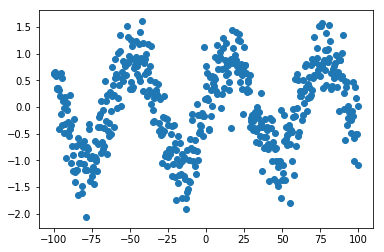

In [27]:
plt.scatter(X, y)

In [28]:
model = nn.Sequential(
    nn.Linear(1, 10), # 10 hidden units
    nn.ReLU(), # sigmoid activation
    nn.Linear(10, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 1) # final prediction
)

In [29]:
Xt = torch.from_numpy(X).type(torch.float32)
yt = torch.from_numpy(y).type(torch.float32)

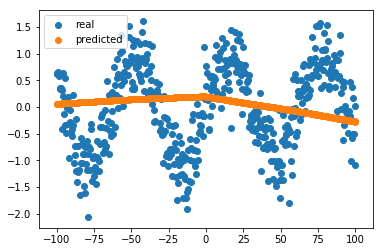

In [30]:
# initial prediction
plt.scatter(X, y)
plt.scatter(X, model.forward(Xt).data.numpy())
plt.legend(['real', 'predicted'])

In [31]:
# nn comes with several predefined packages
loss_function = nn.MSELoss(reduction='sum')
learning_rate = 0.00001

In [32]:
for i in range(5000):
    yp = model.forward(Xt)
    loss = loss_function(yp, yt)
    # reset gradients
    model.zero_grad()
    
    loss.backward()
    
    if i % 500 == 0:
        print(loss)
    # don't grow the graph
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

tensor(333.6453, grad_fn=<MseLossBackward>)
tensor(292.4708, grad_fn=<MseLossBackward>)
tensor(290.1729, grad_fn=<MseLossBackward>)
tensor(287.1142, grad_fn=<MseLossBackward>)
tensor(284.0723, grad_fn=<MseLossBackward>)
tensor(280.1725, grad_fn=<MseLossBackward>)
tensor(274.9623, grad_fn=<MseLossBackward>)
tensor(267.6495, grad_fn=<MseLossBackward>)
tensor(257.6697, grad_fn=<MseLossBackward>)
tensor(244.2865, grad_fn=<MseLossBackward>)


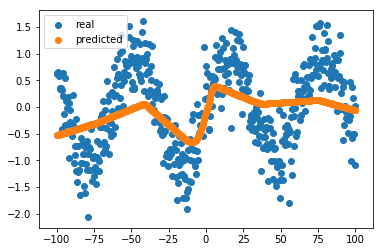

In [33]:
# initial prediction
plt.scatter(X, y)
plt.scatter(X, model.forward(Xt).data.numpy())
plt.legend(['real', 'predicted'])

# Package optim

There are several algorithms better than stochastic gradient descent

In [34]:
model = nn.Sequential(
    nn.Linear(1, 10), # 10 hidden units
    nn.ReLU(), # sigmoid activation
    nn.Linear(10, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 20), # 20 hidden units
    nn.ReLU(),
    nn.Linear(20, 1) # final prediction
)

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(5000):
    yp = model.forward(Xt)
    loss = loss_function(yp, yt)
    # reset gradients
    optimizer.zero_grad()
    
    loss.backward()
    
    if i % 500 == 0:
        print(loss)
    optimizer.step()

tensor(315.0819, grad_fn=<MseLossBackward>)
tensor(299.9580, grad_fn=<MseLossBackward>)
tensor(294.2961, grad_fn=<MseLossBackward>)
tensor(291.4652, grad_fn=<MseLossBackward>)
tensor(289.1334, grad_fn=<MseLossBackward>)
tensor(286.6578, grad_fn=<MseLossBackward>)
tensor(283.8851, grad_fn=<MseLossBackward>)
tensor(280.9672, grad_fn=<MseLossBackward>)
tensor(277.7617, grad_fn=<MseLossBackward>)
tensor(274.0918, grad_fn=<MseLossBackward>)


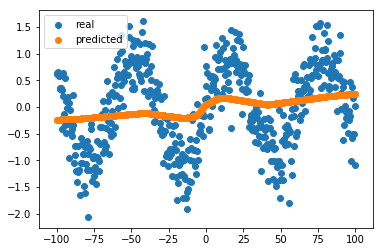

In [36]:
# initial prediction
plt.scatter(X, y)
plt.scatter(X, model.forward(Xt).data.numpy())
plt.legend(['real', 'predicted'])

# Custom modules

In [37]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

In [38]:
model = nn.Sequential(
    nn.Linear(1, 10), # 10 hidden units
    nn.ReLU(), # sigmoid activation
    TwoLayerNet(10, 20, 20),
    nn.Linear(20, 1) # final prediction
)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(5000):
    yp = model.forward(Xt)
    loss = loss_function(yp, yt)
    # reset gradients
    optimizer.zero_grad()
    
    loss.backward()
    
    if i % 500 == 0:
        print(loss)
    optimizer.step()

tensor(1161.2627, grad_fn=<MseLossBackward>)
tensor(293.3873, grad_fn=<MseLossBackward>)
tensor(292.4538, grad_fn=<MseLossBackward>)
tensor(292.3284, grad_fn=<MseLossBackward>)
tensor(292.1781, grad_fn=<MseLossBackward>)
tensor(291.9982, grad_fn=<MseLossBackward>)
tensor(291.7816, grad_fn=<MseLossBackward>)
tensor(291.5215, grad_fn=<MseLossBackward>)
tensor(291.2095, grad_fn=<MseLossBackward>)
tensor(290.8332, grad_fn=<MseLossBackward>)


# Fancy dataset loading

In [40]:
from torch.utils.data import TensorDataset, DataLoader

In [41]:
Xt.shape

torch.Size([500, 1])

In [42]:
# randomize the data
dataloader = DataLoader(TensorDataset(Xt, yt), batch_size=250, 
                        shuffle=True)

In [44]:
for epoch in range(1000):
    for i_batch, sample_batched in enumerate(dataloader):
        yp = model.forward(Xt)
        loss = loss_function(yp, yt)
        # reset gradients
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
    if epoch % 500 == 0:
        print(loss)

tensor(255.5187, grad_fn=<MseLossBackward>)
tensor(248.4363, grad_fn=<MseLossBackward>)
